In [ ]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import re

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
  
uploaded = files.upload()

In [ ]:
West = ['DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL', 'MEM', 'MIN', 'NOP', 'OKC', 'PHO', 'POR', 'SAC', 'SAS', 'UTA']
East = ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DET', 'IND', 'MIA', 'MIL', 'NYK', 'ORL', 'PHI', 'TOR', 'WAS']

In [ ]:
#Create dataframes for each WC team
west_dict = {}
for i in West :
  west_dict[i] = pd.read_csv('{} 2020-2021 (Mar 31).csv'.format(i))
  west_dict[i]['HomeAway'] = west_dict[i]['HomeAway'].replace(np.nan, 0) #Home = 0
  west_dict[i]['HomeAway'] = west_dict[i]['HomeAway'].replace('@', 1) #Away = 1
  west_dict[i]['Opp'] = west_dict[i]['Opp'].replace('CHO', "CHA")
  west_dict[i]['Team'] = i

#Create dataframes for each EC team
east_dict = {}
for j in East :
  east_dict[j] = pd.read_csv('{} 2020-2021 (Mar 31).csv'.format(j))
  east_dict[j]['HomeAway'] = east_dict[j]['HomeAway'].replace(np.nan, 0) #Home = 0
  east_dict[j]['HomeAway'] = east_dict[j]['HomeAway'].replace('@', 1) #Away = 1
  east_dict[j]['Opp'] = east_dict[j]['Opp'].replace('CHO', "CHA")
  east_dict[j]['Team'] = j

In [ ]:
#One dataframe for all WC teams
dfw = pd.DataFrame()
for k in West :
  dfw = dfw.append(west_dict[k], ignore_index = True)

In [ ]:
#One dataframe for all EC teams
dfe = pd.DataFrame()
for m in East :
  dfe = dfe.append(east_dict[m], ignore_index = True)

In [ ]:
#One dataframe for all teams
df = dfw.append(dfe, ignore_index = True)

In [ ]:
#Rename and print column names of the dataframe
df = df.rename(columns = {'Opp' : 'Opponent', 'Tm' : 'Points', 'Opp.1' : 'OppPoints', 'FTr' : 'FTRate', '3PAr' : '3PtRate'})

In [ ]:
#Reorder columns of the dataframe
df = df[['Date', 'Team', 'HomeAway', 'Opponent', 'Points', 'OppPoints', 'ORtg', 'DRtg', 'Pace', 'FTRate', '3PtRate',
         'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'OeFG%', 'OffTOV%', 'OffORB%', 'OffFT/FGA', 'DeFG%', 'DefTOV%', 'DefDRB%', 'DefFT/FGA']]
#Date: date of game
#Team: team that these stats go with
#HomeAway: 0 if Team was home, 1 if away
#Opponent: opponent
#Points: points scored by team
#OppPoints: points scored by opponent
#ORtg: offensive rating of team
#DRtg: defensive rating of team
#Pace: pace of the game
#FTRate: free throw attempts per field goal attempt for team
#3PtRate: percentage of field goal attempts from 3 for team
#TS%: true shooting percentage for team
#TRB%: total rebound percentage for team
#AST%: percentage of field goals that were assisted on for team
#STL%: percentage of opponent's possessions that ended in a steal
#BLK%: percentage of opponent's field goals that were blocked
#OeFG%: team's effective field goal percentage
#OffTOV%: team's turn over percentage
#OffORB%: team's offensive rebound percentage
#OffFT/FGA: team's made free throw per field goal attempt
#DeFG%: opponent's effective field goal percentage for team
#DefTOV%: opponent's turn over percentage
#DefDRB%: team's defensive rebound percentage
#DefFT/FGA: opponent's made free throw per field goal attempt

In [ ]:
#Sort by date
df['Date'] = pd.to_datetime(df.Date)
df = df.sort_values('Date')
df = df.reset_index(drop = True)

In [ ]:
#Create a dataframe for the basic game log data
basic_log = pd.read_csv('NBA Basic Game Log 2020-2021 (Mar 31).csv')

In [ ]:
#Fix HomeAway column and Hornets abbreviation
basic_log['HomeAway'] = basic_log['HomeAway'].replace(np.nan, 0) #Home = 0
basic_log['HomeAway'] = basic_log['HomeAway'].replace('@', 1) #Away = 1
basic_log['Opponent'] = basic_log['Opponent'].replace('CHO', 'CHA')

In [ ]:
#Create a possession variable
basic_log['Possessions'] = 0.5 * ((basic_log['FGA'] + 0.4*basic_log['FTA'] - 1.07*(basic_log['ORB']/(basic_log['ORB']+(basic_log['OppTRB']-basic_log['OppORB']))) *
                                   (basic_log['FGA']-basic_log['FG']) + basic_log['TOV']) + 
                                  (basic_log['OppFGA'] + 0.4*basic_log['OppFTA'] - 1.07*(basic_log['OppORB']/(basic_log['OppORB']+(basic_log['TRB']-basic_log['ORB']))) *
                                   (basic_log['OppFGA']-basic_log['OppFG']) + basic_log['OppTOV']))

In [ ]:
#Create the defensive stats needed and add them to basic_log
basic_log['OppTS%'] = basic_log['OppPoints'] / (2 * (basic_log['OppFGA'] + 0.44 * basic_log['OppFTA']))
basic_log['OppTRB%'] = (basic_log['OppTRB'] / (basic_log['TRB'] + basic_log['OppTRB'])) * 100
basic_log['OppAST%'] = (basic_log['OppAST'] / basic_log['OppFG']) * 100
basic_log['OppTOV%'] = (basic_log['OppTOV'] / (basic_log['OppFGA'] + 0.44 * basic_log['OppFTA'] + basic_log['OppTOV'])) * 100
basic_log['OppORB%'] = (basic_log['OppORB'] / (basic_log['OppORB'] + (basic_log['TRB'] - basic_log['ORB']))) * 100
basic_log['OppFT/FGA'] = basic_log['OppFT'] / basic_log['OppFGA']
basic_log['OppDRB%'] = ((basic_log['OppTRB'] - basic_log['OppORB']) / (((basic_log['OppTRB'] - basic_log['OppORB']) + basic_log['ORB']))) * 100
basic_log['OppSTL%'] = basic_log['OppSTL'] / basic_log['Possessions']
basic_log['OppBLK%'] = basic_log['OppBLK'] / (basic_log['OppFGA'] - basic_log['Opp3PA'])
basic_log['Opp3PtRate'] = basic_log['Opp3PA'] / basic_log['OppFGA']
basic_log['OppFTRate'] = basic_log['OppFTA'] / basic_log['OppFGA']

In [ ]:
#Reorder the columns
basic_log = basic_log[['Date', 'Team', 'HomeAway', 'Opponent', 'Points', 'OppPoints', 'FG',	'FGA',	'FG%',	'3P',	'3PA',	'3P%',	'FT',	'FTA',
                       'FT%',	'ORB',	'TRB',	'AST',	'STL',	'BLK',	'TOV',	'PF',	'OppFG',	'OppFGA',	'OppFG%',	'Opp3P',	'Opp3PA',	'Opp3P%',
                       'OppFT',	'OppFTA',	'OppFT%',	'OppORB',	'OppTRB',	'OppAST',	'OppSTL',	'OppBLK',	'OppTOV',	'OppPF', 'OppTS%', 'OppTRB%',
                       'OppAST%', 'OppTOV%', 'OppORB%', 'OppFT/FGA', 'OppDRB%', 'OppSTL%', 'OppBLK%', 'Opp3PtRate', 'OppFTRate', 'Possessions']]

In [ ]:
#Sort by date
basic_log['Date'] = pd.to_datetime(basic_log.Date)
basic_log = basic_log.sort_values('Date')
basic_log = basic_log.reset_index(drop = True)

In [ ]:
#Add days since last game column to dataframe
def last_game(g) :
  g.sort_values(by = 'Date')
  g['Last_Game'] = g.Date.shift(+1)
  return g

df = df.groupby(df.Team).apply(last_game)
df['Days_Since'] = ''
for i in range(df.shape[0]) :
  df['Days_Since'][i] = (df['Date'][i] - df['Last_Game'][i]).days

df['Days_Since'] = df['Days_Since'].replace(np.nan, 4)
df = df.drop(['Last_Game'], axis = 1)

#Machine Learning and sklearn

In [ ]:
#Multiple Linear Regression using sklearn and Machine Learning
X = df.iloc[:, 2:25]#.values
y = df.iloc[:, 4]#.values
#X = np.delete(X, [1, 2], axis = 1)
X = X.drop(['Opponent', 'Points'], axis = 1)

In [ ]:
#Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#Train the model on the training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#Check accuracy
y_pred = regressor.predict(X_test)
np.set_printoptions(precision = 2)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.values.reshape(len(y_test.values), 1)), axis = 1))
#np.mean(abs(y_pred - y_test))

In [ ]:
#Obtain regression equation
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
#print(coeff_df)
#print(regressor.coef_)
intercept = pd.DataFrame([[regressor.intercept_]], columns = ['Coefficient'], index = ['Intercept'])
regression_df = intercept.append(coeff_df)
print(regression_df)

            Coefficient
Intercept     -4.225932
HomeAway      -0.069941
OppPoints      0.965889
ORtg           0.945142
DRtg          -0.927045
Pace           0.029493
FTRate         0.864654
3PtRate       -0.284621
TS%            8.329850
TRB%           0.027355
AST%          -0.002782
STL%           0.003099
BLK%           0.000706
OeFG%         -1.467898
OffTOV%       -0.061168
OffORB%        0.007606
OffFT/FGA     -1.486191
DeFG%         -3.768512
DefTOV%        0.040379
DefDRB%        0.002434
DefFT/FGA      0.053714
Days_Since     0.006294


In [ ]:
#Create a dataframe with the average of each team's variables from df
col_list = df.columns
All = ['DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL', 'MEM', 'MIN', 'NOP', 'OKC', 'PHO', 'POR', 'SAC', 'SAS', 'UTA', 
       'ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DET', 'IND', 'MIA', 'MIL', 'NYK', 'ORL', 'PHI', 'TOR', 'WAS']
rank = pd.DataFrame()
for t in All :
  temp_team = pd.DataFrame()
  for c in col_list[5:-1] :
    temp = pd.DataFrame([[np.mean(df[df['Team'] == t][c])]], columns = ['{}'.format(c)], index = ['{}'.format(t)])
    temp_team = temp_team.join(temp, how = 'outer')
  rank = rank.append(temp_team)

In [ ]:
#Create a dataframe with the average of each team's variables from basic_log
col_list = basic_log.columns
All = ['DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL', 'MEM', 'MIN', 'NOP', 'OKC', 'PHO', 'POR', 'SAC', 'SAS', 'UTA', 
       'ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DET', 'IND', 'MIA', 'MIL', 'NYK', 'ORL', 'PHI', 'TOR', 'WAS']
rank_basic = pd.DataFrame()
for t in All :
  temp_team = pd.DataFrame()
  for c in col_list[4:-1] :
    temp = pd.DataFrame([[np.mean(basic_log[basic_log['Team'] == t][c])]], columns = ['{}'.format(c)], index = ['{}'.format(t)])
    temp_team = temp_team.join(temp, how = 'outer')
  rank_basic = rank_basic.append(temp_team)

In [ ]:
#Combine the two previously created fataframes and delete duplicate columns
rank_all = pd.concat([rank, rank_basic], axis = 1)
rank_all = rank_all.loc[:, ~rank_all.columns.duplicated()]

In [ ]:
#Create a function that uses similar opponent data to determine a team's score
def sim_pred(t1, t2, ha, ds) :

  #Points lets up by the team when against teams with similar ppg as opponent
  idx = rank_all.sort_values('Points').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  opp_pts = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('Points').iloc[a : b].index.values.tolist()))]['OppPoints'])]],
                        columns = ['OppPoints'], index = [t1])

  #ORtg of team when against teams with similar DRtg as opponent
  idx = rank_all.sort_values('DRtg').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  ortg = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('DRtg').iloc[a : b].index.values.tolist()))]['ORtg'])]],
                        columns = ['ORtg'], index = [t1])

  #DRtg of team when against teams with similar ORtg as opponent
  idx = rank_all.sort_values('ORtg').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  drtg = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('ORtg').iloc[a : b].index.values.tolist()))]['DRtg'])]],
                        columns = ['DRtg'], index = [t1])

  #Pace of team when against teams with similar pace as opponent
  idx = rank_all.sort_values('Pace').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  pace = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('Pace').iloc[a : b].index.values.tolist()))]['Pace'])]],
                        columns = ['Pace'], index = [t1])

  #Variables of team when against teams with similar defensive variables as opponent
  vars = ['FTRate', '3PtRate', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%']
  sim_var = pd.DataFrame()
  for i in vars :
    idx = rank_all.sort_values('Opp{}'.format(i)).index.get_loc(t2)
    if idx - 3 <= 0 :
      a = 0
    else :
      a = idx - 3
    b = idx + 4

    temp = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('Opp{}'.format(i)).iloc[a : b].index.values.tolist()))]['{}'.format(i)])]], 
                          columns = ['{}'.format(i)], index = [t1])
    sim_var = sim_var.join(temp, how = 'outer')

  #OeFG% of team when against teams with similar DeFG% as opponent
  idx = rank_all.sort_values('DeFG%').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  oefg = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('DeFG%').iloc[a : b].index.values.tolist()))]['OeFG%'])]],
                        columns = ['OeFG%'], index = [t1])

  #OffTOV% of team when against teams with similar DefTOV% as opponent
  idx = rank_all.sort_values('DefTOV%').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  offtov = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('DefTOV%').iloc[a : b].index.values.tolist()))]['OffTOV%'])]],
                        columns = ['OffTOV%'], index = [t1])

  #OffORB% of team when against teams with similar OppORB% as opponent
  idx = rank_all.sort_values('OppORB%').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  offorb = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('OppORB%').iloc[a : b].index.values.tolist()))]['OffORB%'])]],
                        columns = ['OffORB%'], index = [t1])

  #OffFT/FGA of team when against teams with similar DefFT/FGA as opponent
  idx = rank_all.sort_values('DefFT/FGA').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  off_ftfga = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('DefFT/FGA').iloc[a : b].index.values.tolist()))]['OffFT/FGA'])]],
                        columns = ['OffFT/FGA'], index = [t1])

  #DeFG% of team when against teams with similar OeFG% as opponent
  idx = rank_all.sort_values('OeFG%').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  defg = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('OeFG%').iloc[a : b].index.values.tolist()))]['DeFG%'])]],
                        columns = ['DeFG%'], index = [t1])

  #DefTOV% of team when against teams with similar OffTOV% as opponent
  idx = rank_all.sort_values('OffTOV%').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  deftov = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('OffTOV%').iloc[a : b].index.values.tolist()))]['DefTOV%'])]],
                        columns = ['DefTOV%'], index = [t1])

  #DefDRB% of team when against teams with similar OppDRB% as opponent
  idx = rank_all.sort_values('OppDRB%').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  defdrb = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('OppDRB%').iloc[a : b].index.values.tolist()))]['DefDRB%'])]],
                        columns = ['DefDRB%'], index = [t1])

  #DefFT/FGA% of team when against teams with similar OffFT/FGA% as opponent
  idx = rank_all.sort_values('OffFT/FGA').index.get_loc(t2)
  if idx - 3 <= 0 :
    a = 0
  else :
    a = idx - 3
  b = idx + 4
  def_ftfga = pd.DataFrame([[np.mean(df[(df['Team'] == t1) & (df['Opponent'].isin(rank_all.sort_values('OffFT/FGA').iloc[a : b].index.values.tolist()))]['DefFT/FGA'])]],
                        columns = ['DefFT/FGA'], index = [t1])
  
  frames = [opp_pts, ortg, drtg, pace, oefg, offtov, offorb, off_ftfga, defg, deftov, defdrb, def_ftfga]
  sim_vars2 = pd.concat(frames, axis = 1)
  frames2 = [sim_var, sim_vars2]
  pred_vars = pd.concat(frames2, axis = 1)
  pred_vars = pred_vars[['OppPoints', 'ORtg', 'DRtg', 'Pace', 'FTRate', '3PtRate', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'OeFG%', 'OffTOV%',
                              'OffORB%', 'OffFT/FGA', 'DeFG%', 'DefTOV%', 'DefDRB%', 'DefFT/FGA']]

  print('{} will score'.format(t1), round(regressor.predict([[ha,pred_vars.iloc[0,0],pred_vars.iloc[0,1],pred_vars.iloc[0,2],pred_vars.iloc[0,3],pred_vars.iloc[0,4],pred_vars.iloc[0,5],
                          pred_vars.iloc[0,6],pred_vars.iloc[0,7],pred_vars.iloc[0,8],pred_vars.iloc[0,9],pred_vars.iloc[0,10],pred_vars.iloc[0,11],
                          pred_vars.iloc[0,12],pred_vars.iloc[0,13],pred_vars.iloc[0,14],pred_vars.iloc[0,15],pred_vars.iloc[0,16],pred_vars.iloc[0,17],
                          pred_vars.iloc[0,18],ds]])[0],2), 'points against {}.'.format(t2))

In [ ]:
#Use the function to make the predictions
#sim_pred(t1, t2, ha, ds)
#t1: Team you want the prediction for
#t2: Opponent
#ha: Home/Away for t1. Home = 0. Away = 1
#ds: Days since the last game t1 played (back to back equals 1, not 0)
sim_pred('DAL', 'MIL', 0, 1)
sim_pred('MIL', 'DAL', 1, 2)

DAL will score 111.18 points against MIL.
MIL will score 116.49 points against DAL.


#Not Machine Learning and not sklearn

In [ ]:
#Multiple Linear Regression
X1 = df[['ORtg', 'Pace', 'HomeAway', 'TS%', 'TRB%', 'AST%', 'OeFG%', 'OffTOV%', 'OffORB%', 'OffFT/FGA', 'DeFG%', 'DefTOV%', 'DefDRB%', 'DefFT/FGA']]
Y = df['Points']

#Add a constant and fit the model
#X = sm.add_constant(X)

#Fit the model
model = sm.OLS(Y, X1).fit()
#predictions = model.predict(X) 

#Print model output
print_model = model.summary()
print(print_model)

In [ ]:
#Calculate Variable Inflation Factors (VIF) for each variable to test for multicollinearity
def calc_vif(x) :
  vif = pd.DataFrame()
  vif['Variables'] = x.columns
  vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

  return vif

calc_vif(X1)

In [ ]:
#Remove the variable with the highest p-value and re-run the model
X2 = df[['ORtg', 'Pace', 'HomeAway', 'TS%', 'TRB%', 'AST%', 'OeFG%', 'OffTOV%', 'OffORB%', 'OffFT/FGA', 'DeFG%', 'DefTOV%', 'DefFT/FGA']]
Y = df['Points']

#X = sm.add_constant(X)
model = sm.OLS(Y, X2).fit()
#predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

In [ ]:
#Remove the variable with the highest p-value and re-run the model
X3 = df[['ORtg', 'Pace', 'HomeAway', 'TS%', 'TRB%', 'AST%', 'OeFG%', 'OffTOV%', 'OffORB%', 'OffFT/FGA', 'DeFG%', 'DefFT/FGA']]
Y = df['Points']

#X = sm.add_constant(X)
model = sm.OLS(Y, X3).fit()
#predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

In [ ]:
#Remove the variable with the highest p-value and re-run the model
X4 = df[['ORtg', 'Pace', 'HomeAway', 'TS%', 'TRB%', 'AST%', 'OeFG%', 'OffTOV%', 'OffORB%', 'OffFT/FGA', 'DeFG%']]
Y = df['Points']

#X = sm.add_constant(X)
model = sm.OLS(Y, X4).fit()
#predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

In [ ]:
#Remove the variable with the highest p-value and re-run the model
X5 = df[['ORtg', 'Pace', 'TS%', 'TRB%', 'AST%', 'OeFG%', 'OffTOV%', 'OffORB%', 'OffFT/FGA', 'DeFG%']]
Y = df['Points']

#X = sm.add_constant(X)
model = sm.OLS(Y, X5).fit()
#predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

In [ ]:
#Remove the variable with the highest p-value and re-run the model
X6 = df[['Pace', 'TS%', 'TRB%', 'AST%', 'OeFG%', 'OffTOV%', 'OffORB%', 'OffFT/FGA', 'DeFG%']]
Y = df['Points']

#X = sm.add_constant(X)
model = sm.OLS(Y, X6).fit()
#predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                 Points   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          9.283e+04
Date:                Fri, 02 Apr 2021   Prob (F-statistic):                        0.00
Time:                        02:09:21   Log-Likelihood:                         -3815.1
No. Observations:                1311   AIC:                                      7648.
Df Residuals:                    1302   BIC:                                      7695.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#Create a dataframe of the average values of the variables in the model for each team
avg_array = []
for m in df['Team'].unique() :
  team_rank_df = df[df['Team'] == m]
  mean_rank_df = team_rank_df.mean(axis = 0)
  pace_rank = mean_rank_df['Pace']
  ts_rank = mean_rank_df['TS%']
  trb_rank = mean_rank_df['TRB%']
  ast_rank = mean_rank_df['AST%']
  oefg_rank = mean_rank_df['OeFG%']
  otov_rank = mean_rank_df['OffTOV%']
  orb_rank = mean_rank_df['OffORB%']
  oft_fga_rank = mean_rank_df['OffFT/FGA']
  defg_rank = mean_rank_df['DeFG%']

  basic_rank_df = basic_log[basic_log['Team'] == m]
  basic_mean_df = basic_rank_df.mean(axis = 0)
  oppts = basic_mean_df['OppTS%']
  opptrb = basic_mean_df['OppTRB%']
  oppast = basic_mean_df['OppAST%']
  opptov = basic_mean_df['OppTOV%']
  opporb = basic_mean_df['OppORB%']
  oppft_fga = basic_mean_df['OppFT/FGA']

  avg_array.append([m, pace_rank, ts_rank, trb_rank, ast_rank, oefg_rank, otov_rank, orb_rank, oft_fga_rank, defg_rank, oppts, opptrb, oppast, opptov, opporb, oppft_fga])

avg_df = pd.DataFrame(avg_array, columns = ['Team', 'Pace', 'TS%', 'TRB%', 'AST%', 'OeFG%', 'TOV%', 'ORB%', 'FT/FGA', 'DeFG%',
                                            'OppTS%', 'OppTRB%', 'OppAST%', 'OppTOV%', 'OppORB%', 'OppFT/FGA'])
#pace_rank_df_sort = pace_rank_df.sort_values('Pace').reset_index(drop = True)
avg_df = avg_df.set_index('Team')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [ ]:
#Create a function to predict a team's points based on their values for that day
def predict_past(date, team) :
  Pace = df[(df['Date'] == date) & (df['Team'] == team)]['Pace'].iloc[0]
  TS = df[(df['Date'] == date) & (df['Team'] == team)]['TS%'].iloc[0]
  TRB = df[(df['Date'] == date) & (df['Team'] == team)]['TRB%'].iloc[0]
  AST = df[(df['Date'] == date) & (df['Team'] == team)]['AST%'].iloc[0]
  OeFG = df[(df['Date'] == date) & (df['Team'] == team)]['OeFG%'].iloc[0]
  OffTOV = df[(df['Date'] == date) & (df['Team'] == team)]['OffTOV%'].iloc[0]
  OffORB = df[(df['Date'] == date) & (df['Team'] == team)]['OffORB%'].iloc[0]
  OffFT_FGA = df[(df['Date'] == date) & (df['Team'] == team)]['OffFT/FGA'].iloc[0]
  DeFG = df[(df['Date'] == date) & (df['Team'] == team)]['DeFG%'].iloc[0]

  X_pred = [Pace, TS, TRB, AST, OeFG, OffTOV, OffORB, OffFT_FGA, DeFG]
  y_pred = model.predict(X_pred)
  print(team, 'is predicted to score', round(y_pred[0], 2))
  print(team, 'really scored', df[(df['Date'] == date) & (df['Team'] == team)]['Points'].iloc[0])
  #return round(y_pred[0], 2)

predict_past('2021-03-23', 'LAL')
predict_past('2021-03-23', 'NOP')

LAL is predicted to score 111.3
LAL really scored 111
NOP is predicted to score 123.41
NOP really scored 128


In [ ]:
#Create a function to predict a team's points based on their average values
def predict_future_avg(team1, team2) :

  mean_pace = (avg_df.loc[team1, 'Pace'] + avg_df.loc[team2, 'Pace']) / 2
  mean_ts1 = (avg_df.loc[team1, 'TS%'] + avg_df.loc[team2, 'OppTS%']) / 2
  mean_trb1 = (avg_df.loc[team1, 'TRB%'] + avg_df.loc[team2, 'OppTRB%']) / 2
  mean_ast1 = (avg_df.loc[team1, 'AST%'] + avg_df.loc[team2, 'OppAST%']) / 2
  mean_oefg1 = (avg_df.loc[team1, 'OeFG%'] + avg_df.loc[team2, 'DeFG%']) / 2
  mean_otov1 = (avg_df.loc[team1, 'TOV%'] + avg_df.loc[team2, 'OppTOV%']) / 2
  mean_orb1 = (avg_df.loc[team1, 'ORB%'] + avg_df.loc[team2, 'OppORB%']) / 2
  mean_oft_fga1 = (avg_df.loc[team1, 'FT/FGA'] + avg_df.loc[team2, 'OppFT/FGA']) / 2
  mean_defg1 = (avg_df.loc[team1, 'DeFG%'] + avg_df.loc[team2, 'OeFG%']) / 2

  mean_ts2 = (avg_df.loc[team2, 'TS%'] + avg_df.loc[team1, 'OppTS%']) / 2
  mean_trb2 = (avg_df.loc[team2, 'TRB%'] + avg_df.loc[team1, 'OppTRB%']) / 2
  mean_ast2 = (avg_df.loc[team2, 'AST%'] + avg_df.loc[team1, 'OppAST%']) / 2
  mean_oefg2 = (avg_df.loc[team2, 'OeFG%'] + avg_df.loc[team1, 'DeFG%']) / 2
  mean_otov2 = (avg_df.loc[team2, 'TOV%'] + avg_df.loc[team1, 'OppTOV%']) / 2
  mean_orb2 = (avg_df.loc[team2, 'ORB%'] + avg_df.loc[team1, 'OppORB%']) / 2
  mean_oft_fga2 = (avg_df.loc[team2, 'FT/FGA'] + avg_df.loc[team1, 'OppFT/FGA']) / 2
  mean_defg2 = (avg_df.loc[team2, 'DeFG%'] + avg_df.loc[team1, 'OeFG%']) / 2

  X_future1 = [mean_pace, mean_ts1, mean_trb1, mean_ast1, mean_oefg1, mean_otov1, mean_orb1, mean_oft_fga1, mean_defg1]
  y_future1 = model.predict(X_future1)

  X_future2 = [mean_pace, mean_ts2, mean_trb2, mean_ast2, mean_oefg2, mean_otov2, mean_orb2, mean_oft_fga2, mean_defg2]
  y_future2 = model.predict(X_future2)

  print(team1, 'is predicted to score', round(y_future1[0], 2))
  print(team2, 'is predicted to score', round(y_future2[0], 2))

predict_future_avg('POR', 'ORL')

POR is predicted to score 113.67
ORL is predicted to score 110.77


In [ ]:
mu = avg_df.mean(axis = 0).transpose()
mu.name = 'Mean'

sd = avg_df.std(axis = 0).transpose()
sd.name = 'St_Dev'

avg_df = avg_df.append(mu)
avg_df = avg_df.append(sd)

,Pace,TS%,TRB%,AST%,OeFG%,TOV%,ORB%,FT/FGA,DeFG%,OppTS%,OppTRB%,OppAST%,OppTOV%,OppORB%,OppFT/FGA
Team,,,,,,,,,,,,,,,
GSW,102.404444,0.574356,46.928889,67.160000,0.540578,12.804444,17.075556,0.194333,0.522889,0.566793,53.105225,59.239032,12.907767,23.526616,0.227054
LAC,96.593478,0.601522,51.756522,57.732609,0.566130,11.132609,22.406522,0.194435,0.537652,0.569490,48.189460,56.604858,11.482562,19.999730,0.186451
LAL,98.288889,0.576044,51.911111,59.366667,0.542956,13.053333,22.597778,0.207956,0.524133,0.552627,48.126314,62.844292,12.842077,19.920900,0.171133
BKN,99.246667,0.613311,50.817778,61.037778,0.579756,12.086667,21.144444,0.209156,0.537200,0.568748,48.893192,58.024978,10.651607,22.104726,0.184352
CHI,99.958140,0.583000,51.230233,61.544186,0.552302,13.534884,21.704651,0.170163,0.536279,0.575469,48.522635,57.033612,11.466153,20.236338,0.205141
CHA,98.925581,0.576674,49.620930,67.141860,0.543256,13.213953,23.304651,0.192302,0.558442,0.579104,50.304977,66.242815,12.852500,23.352117,0.168088
BOS,97.145455,0.573523,51.072727,55.011364,0.542705,11.854545,25.236364,0.187227,0.542545,0.581439,49.155800,59.028909,12.457751,22.619142,0.217572
ATL,96.902273,0.576205,51.843182,60.722727,0.532182,12.013636,25.747727,0.234636,0.523432,0.566508,48.511271,58.846824,10.877433,23.032610,0.201181
UTA,98.195349,0.598093,52.823256,57.618605,0.565070,12.197674,24.851163,0.201628,0.510837,0.537735,47.167341,54.981991,9.993215,21.248947,0.163001


In [ ]:
#Create a function to predict a team's points based on adjusted values
def predict_future_adj(team1, team2) :
  
  adj_pace = (avg_df.loc[team1, 'Pace'] + avg_df.loc[team2, 'Pace']) / 2

  adj_ts1 = avg_df.loc[team1, 'TS%'] + ((avg_df.loc[team2, 'OppTS%'] - avg_df.loc['Mean', 'OppTS%']) / avg_df.loc['St_Dev', 'OppTS%']) * avg_df.loc['St_Dev', 'TS%']
  adj_trb1 = avg_df.loc[team1, 'TRB%'] + ((avg_df.loc[team2, 'OppTRB%'] - avg_df.loc['Mean', 'OppTRB%']) / avg_df.loc['St_Dev', 'OppTRB%']) * avg_df.loc['St_Dev', 'TRB%']
  adj_ast1 = avg_df.loc[team1, 'AST%'] + ((avg_df.loc[team2, 'OppAST%'] - avg_df.loc['Mean', 'OppAST%']) / avg_df.loc['St_Dev', 'OppAST%']) * avg_df.loc['St_Dev', 'AST%']
  adj_oefg1 = avg_df.loc[team1, 'OeFG%'] + ((avg_df.loc[team2, 'DeFG%'] - avg_df.loc['Mean', 'DeFG%']) / avg_df.loc['St_Dev', 'DeFG%']) * avg_df.loc['St_Dev', 'OeFG%']
  adj_otov1 = avg_df.loc[team1, 'TOV%'] + ((avg_df.loc[team2, 'OppTOV%'] - avg_df.loc['Mean', 'OppTOV%']) / avg_df.loc['St_Dev', 'OppTOV%']) * avg_df.loc['St_Dev', 'TOV%']
  adj_orb1 = avg_df.loc[team1, 'ORB%'] + ((avg_df.loc[team2, 'OppORB%'] - avg_df.loc['Mean', 'OppORB%']) / avg_df.loc['St_Dev', 'OppORB%']) * avg_df.loc['St_Dev', 'ORB%']
  adj_oft_fga1 = avg_df.loc[team1, 'FT/FGA'] + ((avg_df.loc[team2, 'OppFT/FGA'] - avg_df.loc['Mean', 'OppFT/FGA']) / avg_df.loc['St_Dev', 'OppFT/FGA']) * avg_df.loc['St_Dev', 'FT/FGA']
  adj_defg1 = avg_df.loc[team1, 'DeFG%'] + ((avg_df.loc[team2, 'OeFG%'] - avg_df.loc['Mean', 'OeFG%']) / avg_df.loc['St_Dev', 'OeFG%']) * avg_df.loc['St_Dev', 'DeFG%']

  adj_ts2 = avg_df.loc[team2, 'TS%'] + ((avg_df.loc[team1, 'OppTS%'] - avg_df.loc['Mean', 'OppTS%']) / avg_df.loc['St_Dev', 'OppTS%']) * avg_df.loc['St_Dev', 'TS%']
  adj_trb2 = avg_df.loc[team2, 'TRB%'] + ((avg_df.loc[team1, 'OppTRB%'] - avg_df.loc['Mean', 'OppTRB%']) / avg_df.loc['St_Dev', 'OppTRB%']) * avg_df.loc['St_Dev', 'TRB%']
  adj_ast2 = avg_df.loc[team2, 'AST%'] + ((avg_df.loc[team1, 'OppAST%'] - avg_df.loc['Mean', 'OppAST%']) / avg_df.loc['St_Dev', 'OppAST%']) * avg_df.loc['St_Dev', 'AST%']
  adj_oefg2 = avg_df.loc[team2, 'OeFG%'] + ((avg_df.loc[team1, 'DeFG%'] - avg_df.loc['Mean', 'DeFG%']) / avg_df.loc['St_Dev', 'DeFG%']) * avg_df.loc['St_Dev', 'OeFG%']
  adj_otov2 = avg_df.loc[team2, 'TOV%'] + ((avg_df.loc[team1, 'OppTOV%'] - avg_df.loc['Mean', 'OppTOV%']) / avg_df.loc['St_Dev', 'OppTOV%']) * avg_df.loc['St_Dev', 'TOV%']
  adj_orb2 = avg_df.loc[team2, 'ORB%'] + ((avg_df.loc[team1, 'OppORB%'] - avg_df.loc['Mean', 'OppORB%']) / avg_df.loc['St_Dev', 'OppORB%']) * avg_df.loc['St_Dev', 'ORB%']
  adj_oft_fga2 = avg_df.loc[team2, 'FT/FGA'] + ((avg_df.loc[team1, 'OppFT/FGA'] - avg_df.loc['Mean', 'OppFT/FGA']) / avg_df.loc['St_Dev', 'OppFT/FGA']) * avg_df.loc['St_Dev', 'FT/FGA']
  adj_defg2 = avg_df.loc[team2, 'DeFG%'] + ((avg_df.loc[team1, 'OeFG%'] - avg_df.loc['Mean', 'OeFG%']) / avg_df.loc['St_Dev', 'OeFG%']) * avg_df.loc['St_Dev', 'DeFG%']

  X_adj1 = [adj_pace, adj_ts1, adj_trb1, adj_ast1, adj_oefg1, adj_otov1, adj_orb1, adj_oft_fga1, adj_defg1]
  #X_adj1 = [90.5, .509, 46.7, 68.8, .474, 10.9, 17.8, .231, .465]
  y_adj1 = model.predict(X_adj1)

  X_adj2 = [adj_pace, adj_ts2, adj_trb2, adj_ast2, adj_oefg2, adj_otov2, adj_orb2, adj_oft_fga2, adj_defg2]
  #X_adj2 = [90.5, .482, 53.3, 67.6, .465, 12.6, 24.4, .094, .474]
  y_adj2 = model.predict(X_adj2)

  #print(adj_ts1, adj_trb1, adj_ast1, adj_oefg1, adj_otov1)
  print(team1, 'is predicted to score', round(y_adj1[0], 2))
  print(team2, 'is predicted to score', round(y_adj2[0], 2))

predict_future_adj('LAL', 'NOP')

LAL is predicted to score 116.41
NOP is predicted to score 108.34


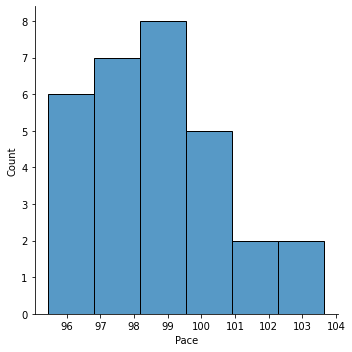

In [ ]:
sns.displot(data = avg_df, x = 'Pace')

In [ ]:
#Convert variable columns into lists and put those lists into one array
A = df['ORtg'].tolist()
B = df['Pace'].tolist()
C = df['HomeAway'].tolist()
Z = np.array([A,B,C])

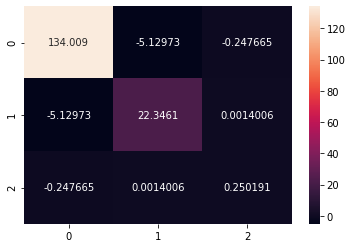

In [ ]:
#Calculate the covariance matrix
covMatrix = np.cov(Z, bias = False)
sns.heatmap(covMatrix, annot = True, fmt = 'g')
plt.show()

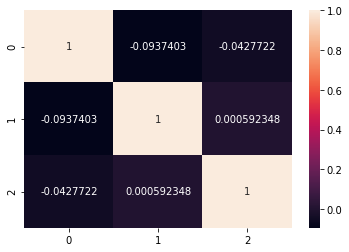

In [ ]:
#Calculate the correlation matrix
corrMatrix = np.corrcoef(Z)
sns.heatmap(corrMatrix, annot = True, fmt = 'g')
plt.show()

In [ ]:
#Perform a t-test to determine if variables change when a team is home vs away
#H0: The two groups have equal means
#H1: The two groups do not have equal means
#If p-value <= 0.05, reject the null
#If p-value > 0.05, do not reject the null
def home_away_t(team, column) :
  home = df[(df['HomeAway'] == 0) & (df['Team'] == team)]
  away = df[(df['HomeAway'] == 1) & (df['Team'] == team)]

  t = stats.ttest_ind(home[column], away[column], equal_var = False)
  return t

home_away_t('LAL', 'DRtg')

Ttest_indResult(statistic=-0.24332976845071858, pvalue=0.8089736055614513)

In [ ]:
#Plot a team's points vs another variable
def pts_vs(team, variable, title, ylab) :
  off_dist = df[df['Team'] == team]
  def_dist = df[df['Opp'] == team]

  plt.figure(figsize = (10,10))
  plt.scatter(off_dist['Tm'], def_dist[variable])
  plt.title("Team's Points vs {}".format(title))
  plt.xlabel('Points Scored')
  plt.ylabel("{}".format(ylab))

pts_vs('LAL', 'Pace', 'Pace of the Game', 'Pace')

In [ ]:
sns.jointplot(west_dict['LAL']['Tm'], west_dict['LAL']['Pace'])